# Демонстрация метрики для регрессии

In [1]:
# расширяем поле, убираем предупреждения
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:95% !important;}</style>'))

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Стандартные библиотеки для анализа
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pylab as pl

In [3]:
import sys
sys.path.append('../')

# Наша разработанная библиотека
from autobinary import target_dist, AutoTrees, base_pipe, RegressionMetrics

In [4]:
import sklearn as sk
import xgboost as xgb
import matplotlib as mplot
import autobinary as ab
import shap

print('pandas: ', pd.__version__)
print('sklearn: ', sk.__version__)
print('xgboost: ', xgb.__version__)
print('matplotlib: ', mplot.__version__)
print('autobinary: ', ab.__version__)

pandas:  1.5.3
sklearn:  1.1.3
xgboost:  1.5.2
matplotlib:  3.7.0
autobinary:  1.0.9


In [5]:
sample = pd.read_csv('../data/train_houseprice.csv')

print('Размерность данных:', sample.shape)
sample.head(2)

Размерность данных: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [6]:
num_columns = [
    'LotArea', 'LotFrontage', 'TotalBsmtSF', 'PoolArea', 'FullBath'
]

cat_columns = [
    'BldgType', 'CentralAir', 'GarageQual', 'Fence', 'SaleType'
]

target = ['SalePrice']

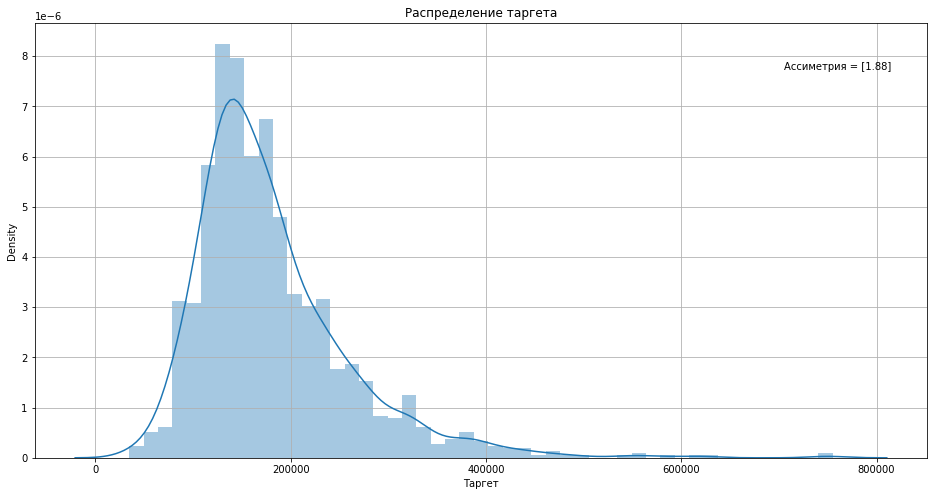

In [7]:
# График распределения непрерывной целевой переменной

target_dist(sample,target)

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(
    sample,
    sample[target],
    test_size=0.3,
    random_state=42
)

In [9]:
prep_pipe = base_pipe(
    num_columns=num_columns, 
    cat_columns=cat_columns)

Определены количественные и категориальные переменные!


In [10]:
prep_pipe.fit(X_train, y_train)

new_X_train = prep_pipe.transform(X_train)
new_X_valid = prep_pipe.transform(X_valid)

In [11]:
# создаем экземпляр класса XGBRegressor
xgb_model = xgb.XGBRegressor(
    eta=0.01,
    n_estimators=1000,
    subsample=0.9,
    colsample_bytree=0.6,
    max_depth = 6,
    objective='reg:squarederror',
    use_label_encoder=False,
    n_jobs=-1,
    random_state=42)

In [12]:
xgb_model.fit(new_X_train, y_train);

## 1. Кастомная метрика

In [13]:
df_train = pd.DataFrame()
df_train['target'] = y_train
df_train['prediction'] = xgb_model.predict(new_X_train)

df_train.head(2)

,target,prediction
135,174000,174957.84375
1452,145000,131769.43750


In [14]:
df_valid = pd.DataFrame()
df_valid['target'] = y_valid
df_valid['prediction'] = xgb_model.predict(new_X_valid)

df_valid.head(2)

,target,prediction
892,154500,132491.046875
1105,325000,266899.875000


### 1.1 TRAIN метрики для регрессии

In [15]:
# Инициализация класса метрик для регрессии

metr_train = RegressionMetrics(df_train, target='target')

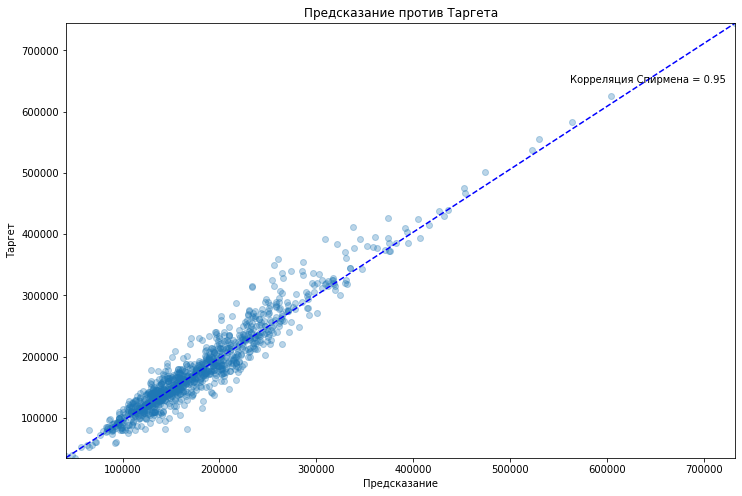

In [16]:
# Диаграмма рассеивания (target vs prediction), Корреляция Спирмена для трейна

metr_train.plot_prediction()

In [17]:
# Расчет метрик MAPE и SMAPE по бинам для трейна

metr_train.m_bin_table(5)

,target,prediction,mape,smape,target_range,mape_range,smape_range
135,174000,174957.843750,0.550485,0.548974,148 200 - 179 900,-10 до 10,-10 до 10
1452,145000,131769.437500,-9.124526,-9.560711,124 000 - 148 200,-10 до 10,-10 до 10
762,215200,211842.046875,-1.560387,-1.572657,179 900 - 230 400,-10 до 10,-10 до 10
932,320000,317479.750000,-0.787578,-0.790692,> 230 400,-10 до 10,-10 до 10
435,212000,193814.250000,-8.578184,-8.962598,179 900 - 230 400,-10 до 10,-10 до 10
...,...,...,...,...,...,...,...
1095,176432,210977.921875,19.580304,17.834299,148 200 - 179 900,10 до 50,10 до 50
1130,135000,165182.796875,22.357627,20.109611,124 000 - 148 200,10 до 50,10 до 50
1294,115000,126109.906250,9.660788,9.215636,< 124 000,-10 до 10,-10 до 10
860,189950,145776.000000,-23.255594,-26.315507,179 900 - 230 400,-50 до -10,-50 до -10


Всего записей в выборке:  1022
----------
Минимальное значение таргета: 34 900 
Максимальное значение таргета: 745 000


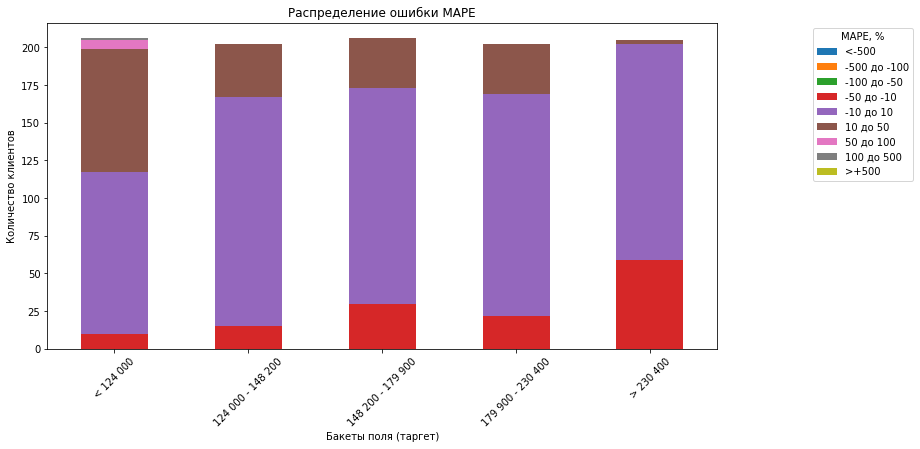

In [18]:
# Визуализация MAPE по бинам для трейна

metr_train.target_describe()
metr_train.m_bin_plot('mape')

Всего записей в выборке:  1022
----------
Минимальное значение таргета: 34 900 
Максимальное значение таргета: 745 000


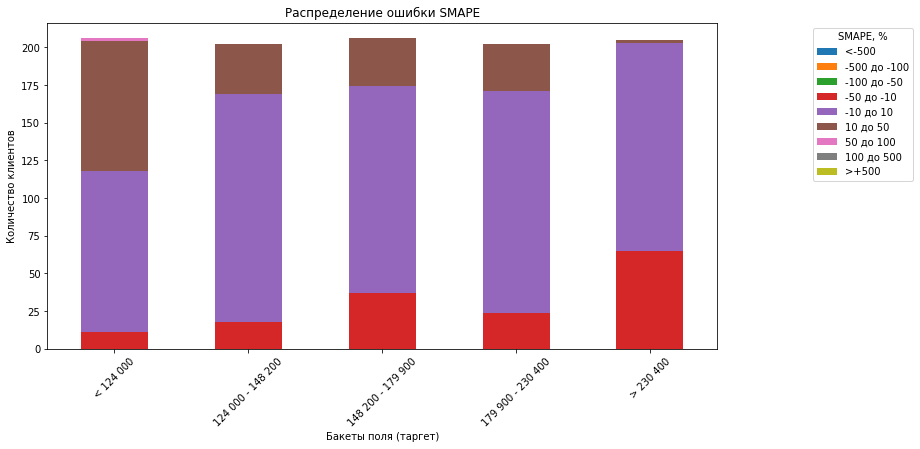

In [19]:
# Визуализация SMAPE по бинам для трейна

metr_train.target_describe()
metr_train.m_bin_plot('smape')

### 1.2 TEST

In [20]:
# Инициализация

metr_valid = RegressionMetrics(df_valid, target='target')

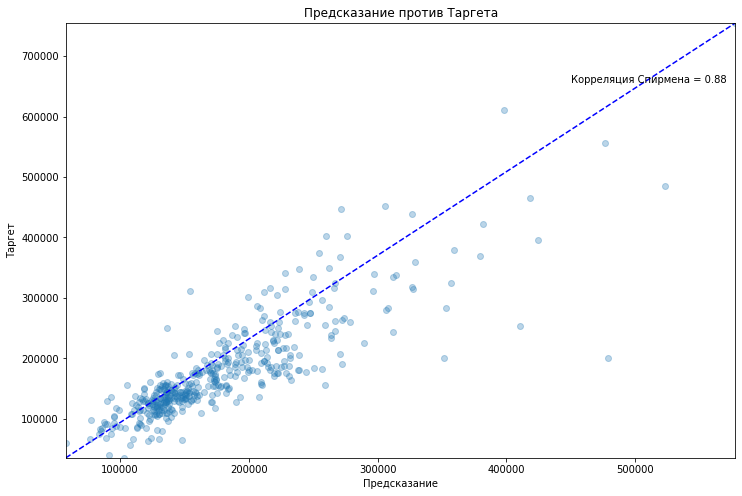

In [21]:
# Диаграмма рассеивания (target vs prediction), Корреляция Спирмена для теста

metr_valid.plot_prediction()

In [22]:
# Расчет метрик MAPE и SMAPE по бинам для теста

metr_valid.m_bin_table(5)

,target,prediction,mape,smape,target_range,mape_range,smape_range
892,154500,132491.046875,-14.245277,-15.337728,144 400 - 176 300,-50 до -10,-50 до -10
1105,325000,266899.875000,-17.876962,-19.631741,> 227 500,-50 до -10,-50 до -10
413,115000,134133.265625,16.637622,15.359864,< 124 200,10 до 50,10 до 50
522,159000,155032.531250,-2.495263,-2.526788,144 400 - 176 300,-10 до 10,-10 до 10
1036,315500,266211.437500,-15.622365,-16.946052,> 227 500,-50 до -10,-50 до -10
...,...,...,...,...,...,...,...
331,139000,138715.250000,-0.204856,-0.205066,124 200 - 144 400,-10 до 10,-10 до 10
323,126175,122019.156250,-3.293714,-3.348865,124 200 - 144 400,-10 до 10,-10 до 10
650,205950,180101.359375,-12.550930,-13.391296,176 300 - 227 500,-50 до -10,-50 до -10
439,110000,141611.296875,28.737543,25.127089,< 124 200,10 до 50,10 до 50


Всего записей в выборке:  438
----------
Минимальное значение таргета: 35 311 
Максимальное значение таргета: 755 000


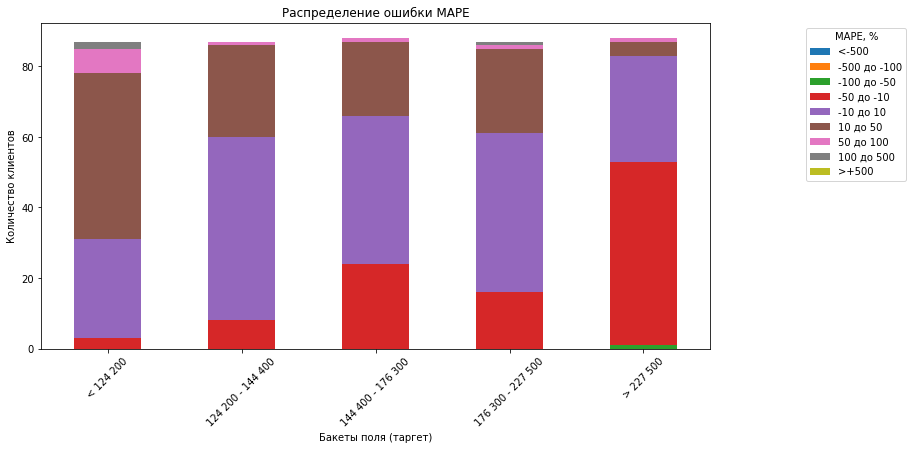

In [23]:
# Визуализация MAPE по бинам для теста

metr_valid.target_describe()
metr_valid.m_bin_plot('mape')

Всего записей в выборке:  438
----------
Минимальное значение таргета: 35 311 
Максимальное значение таргета: 755 000


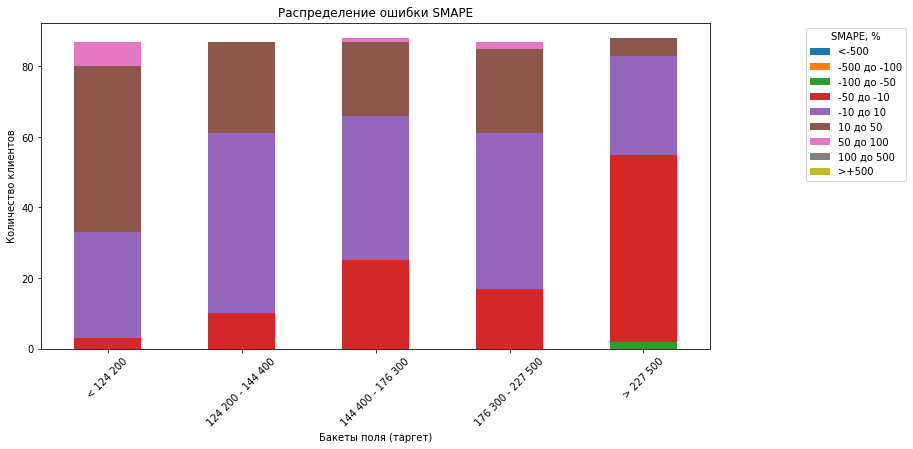

In [24]:
# Визуализация SMAPE по бинам для теста

metr_valid.target_describe()
metr_valid.m_bin_plot('smape')